# Synthetic Dataset FCUBE and `FCUBEPartitioner`

FCUBE is a synthetic dataset for research in non-IID scenario with feature imbalance. This dataset is proposed in [Federated Learning on Non-IID Data Silos: An Experimental Study](https://arxiv.org/abs/2102.02079).

Data points of FCUBE contain 3 features, that is, $\mathcal{D}_{\text{FCUBE}} = \{ (\mathbf{x}, y) \}$, where each data point $\mathbf{x} = (x_1, x_2, x_3)$, and label $y \in \{ 0, 1 \}$. The distribution of data points is a cube in three dimentions, and if $x_1 > 0$, then $y = 0$, while $y=1$ when $x_1 < 0$. By default, we suggest 4000 data points for trainset, and 1000 for testset.

For more details, please refer to Section (IV-B-b) of original paper.

In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
# %matplotlib notebook
import pandas as pd
import numpy as np

import sys
sys.path.append('../../../')

from fedlab.contrib.dataset.fcube import FCUBE
from fedlab.utils.dataset import FCUBEPartitioner
from fedlab.utils.functional import partition_report

import torch
from torch.utils.data import DataLoader

Dataset `FCUBE` will generate local `.npy` file if `generate=True`. And it also accepts common arguments for dataset: `transform` and `target_transform` to transform the input and target respectively.

## Dataset

### Generation

In [2]:
trainset = FCUBE('../../../../data/FCUBE/', train=True, generate=True,
                 num_samples=1000)
train_loader = DataLoader(trainset, batch_size=20, shuffle=True)

Generate FCUBE data now...
../../../../data/FCUBE/fcube_train_X_1000.npy generated.
../../../../data/FCUBE/fcube_train_y_1000.npy generated.


In [3]:
testset = FCUBE('../../../../data/FCUBE/', train=False, generate=True,
                 num_samples=250)
test_loader = DataLoader(testset, batch_size=20, shuffle=False)

Generate FCUBE data now...
../../../../data/FCUBE/fcube_test_X_250.npy generated.
../../../../data/FCUBE/fcube_test_y_250.npy generated.


### Dataset Visualization

In [4]:
train_df = pd.DataFrame({'x1': trainset.data[:,0],
                         'x2': trainset.data[:,1],
                         'x3': trainset.data[:,2],
                         'y': trainset.targets, 
                         'split': ['train'] * trainset.targets.shape[0]})
test_df = pd.DataFrame({'x1': testset.data[:,0],
                        'x2': testset.data[:,1],
                        'x3': testset.data[:,2],
                        'y': testset.targets, 
                        'split': ['test'] * testset.targets.shape[0]})
fcube_df = pd.concat([train_df, test_df], ignore_index=True)

Visualization of class distribution in trainset/testset:

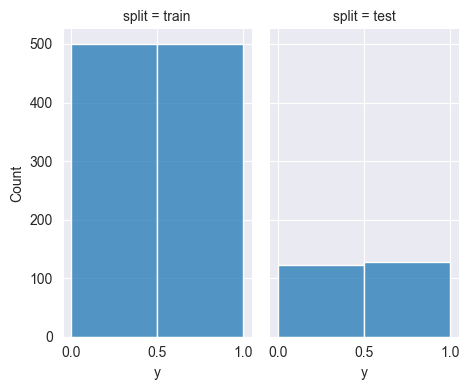

In [6]:
sns.set_style('darkgrid')
sns.displot(fcube_df, x="y", col="split", bins=2, height=4, aspect=.6)
plt.savefig(f"./imgs/fcube_class_dist.png", dpi=400, bbox_inches = 'tight')

Data points distribution for trainset:

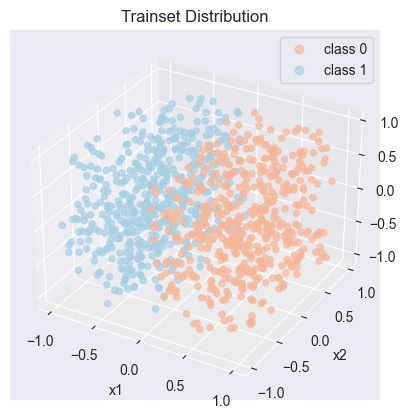

<Figure size 640x480 with 0 Axes>

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("RdBu", 2).as_hex())

scatter = ax.scatter(train_df['x1'], train_df['x2'], train_df['x3'], c=train_df['y'], marker='o', 
           cmap=cmap, 
           alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=['class 0','class 1'])
plt.title("Trainset Distribution")
plt.show()
plt.savefig("./imgs/fcube_train_dist_vis.png",  dpi=400, bbox_inches='tight')

Data points distribution for testset:

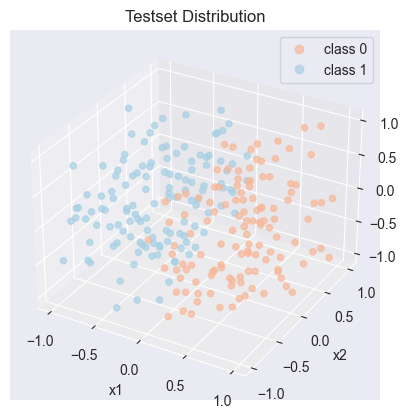

<Figure size 640x480 with 0 Axes>

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("RdBu", 2).as_hex())

scatter = ax.scatter(test_df['x1'], test_df['x2'], test_df['x3'], c=test_df['y'], marker='o', 
           cmap=cmap, 
           alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=['class 0','class 1'])
plt.title("Testset Distribution")
plt.show()
plt.savefig("./imgs/fcube_test_dist_vis.png",  dpi=400, bbox_inches='tight')

## Data Partition

FCUBE only supports 2 partition methods:
- feature distribution skew: synthetic
- IID

Limited by synthetic partition, client number for FCUBE can only be 4. 

In [9]:
num_clients = 4
num_classes = 2
col_names = [f"class{i}" for i in range(num_classes)]

### Synthetic partition

From dataset visualization, we can see that the distribution of FCUBE data points is in a cube with $-1 < x_1 < 1$, $-1 < x_2 < 1$, $-1 < x_3 < 1$. 

In `'synthetic'` partition, the cube is divided into 8 parts by plane $x_1=0$, $x_2=0$, and $x_3=0$. Then, each pair of parts which are symmetric of $(0,0,0)$ is allocated for each client. In this way, feature distribution varies among parties while labels are still balanced. 

Visualization from original paper: 
<img src="../imgs/fcube_synthetic_original_paper.png" width=500>

In [10]:
# perform partition
synthetic_part = FCUBEPartitioner(trainset.data, partition="synthetic")
# save to pkl file
# torch.save(synthetic_part.client_dict, "fcube_synthetic.pkl")
print(f"Client number: {len(synthetic_part)}")

Client number: 4


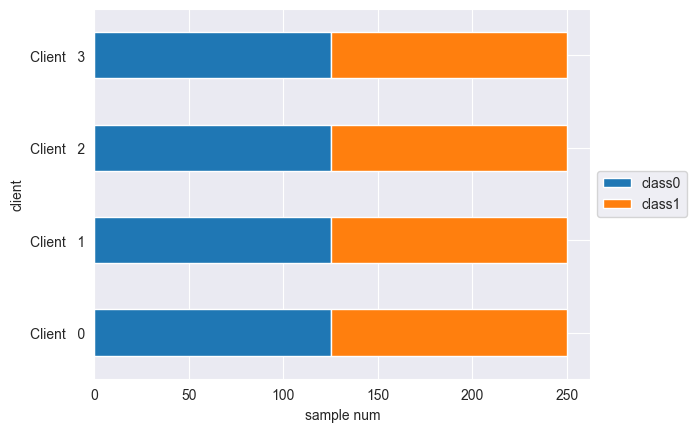

In [12]:
csv_file = "./partition-reports/fcube_synthetic.csv"
partition_report(trainset.targets, synthetic_part.client_dict, 
                 class_num=num_classes, 
                 verbose=False, file=csv_file)

synthetic_part_df = pd.read_csv(csv_file,header=1)
synthetic_part_df = synthetic_part_df.set_index('client')
col_names = [f"class{i}" for i in range(num_classes)]
for col in col_names:
    synthetic_part_df[col] = (synthetic_part_df[col] * synthetic_part_df['Amount']).astype(int)

# select first 4 clients for bar plot
synthetic_part_df[col_names].plot.barh(stacked=True)  
# plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('sample num')
plt.savefig(f"./imgs/fcube_synthetic.png", dpi=400, bbox_inches = 'tight')

Visualization of data points for each client:

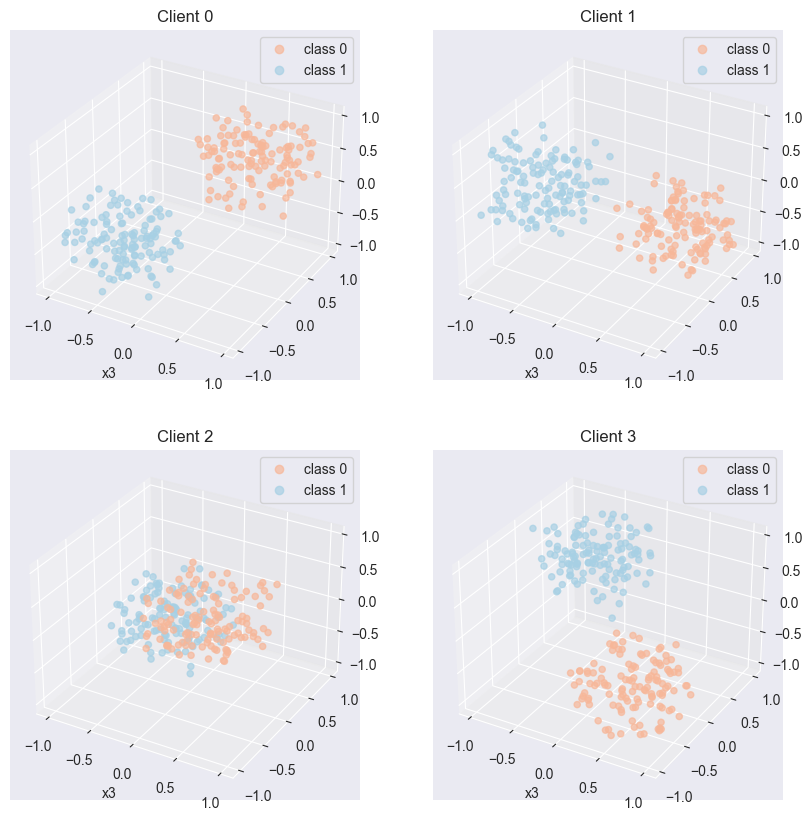

<Figure size 640x480 with 0 Axes>

In [13]:
# extract data and targets for each clients
client_data = [trainset.data[synthetic_part[cid]] for cid in range(num_clients)]
client_targets = [trainset.targets[synthetic_part[cid]] for cid in range(num_clients)]


fig = plt.figure(figsize=(10,10))
# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("RdBu", 2).as_hex())

for row in range(2):
    for col in range(2):
        cid = int(2*row + col)
        ax = fig.add_subplot(2, 2, cid+1, projection='3d', title=f"Client {cid}")
        ax.set_xlabel("x1")
        ax.set_xlabel("x2")
        ax.set_xlabel("x3")
        scatter = ax.scatter(client_data[cid][:,0], 
                            client_data[cid][:,1], 
                            client_data[cid][:,2], 
                            c=client_targets[cid], 
                            marker='o',  
                            cmap=cmap, 
                            alpha=0.7)
        ax.legend(handles=scatter.legend_elements()[0], labels=['class 0','class 1'])


plt.show()
plt.savefig("./imgs/fcube_synthetic_part.png",  dpi=500, bbox_inches='tight')

### IID partition

In [14]:
# perform partition
iid_part = FCUBEPartitioner(trainset.data, partition="iid")
# save to pkl file
# torch.save(iid_part.client_dict, "fcube_iid.pkl")
print(f"Client number: {len(iid_part)}")

Client number: 4


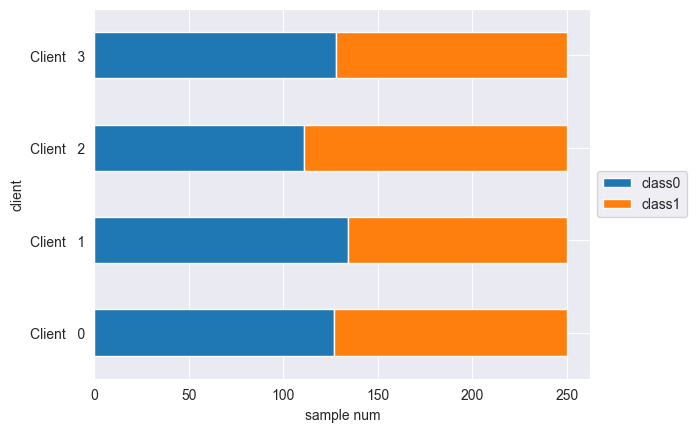

In [15]:
csv_file = "./partition-reports/fcube_iid.csv"
partition_report(trainset.targets, iid_part.client_dict, 
                 class_num=num_classes, 
                 verbose=False, file=csv_file)

iid_part_df = pd.read_csv(csv_file,header=1)
iid_part_df = iid_part_df.set_index('client')
for col in col_names:
    iid_part_df[col] = (iid_part_df[col] * iid_part_df['Amount']).astype(int)

# select first 4 clients for bar plot
iid_part_df[col_names].plot.barh(stacked=True)  
# plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('sample num')
plt.savefig(f"./imgs/fcube_iid.png", dpi=400, bbox_inches = 'tight')

Visualization of data points for each client:

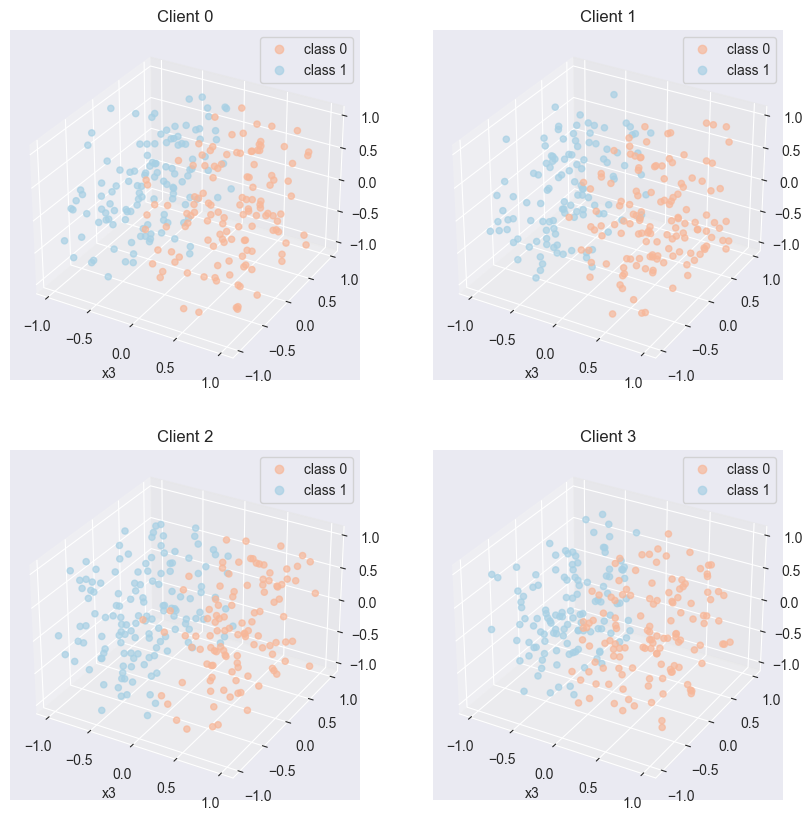

<Figure size 640x480 with 0 Axes>

In [16]:
# extract data and targets for each clients
client_data = [trainset.data[iid_part[cid]] for cid in range(num_clients)]
client_targets = [trainset.targets[iid_part[cid]] for cid in range(num_clients)]


fig = plt.figure(figsize=(10,10))
# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("RdBu", 2).as_hex())

for row in range(2):
    for col in range(2):
        cid = int(2*row + col)
        ax = fig.add_subplot(2, 2, cid+1, projection='3d', title=f"Client {cid}")
        ax.set_xlabel("x1")
        ax.set_xlabel("x2")
        ax.set_xlabel("x3")
        scatter = ax.scatter(client_data[cid][:,0], 
                            client_data[cid][:,1], 
                            client_data[cid][:,2], 
                            c=client_targets[cid], 
                            marker='o',  
                            cmap=cmap, 
                            alpha=0.7)
        ax.legend(handles=scatter.legend_elements()[0], labels=['class 0','class 1'])


plt.show()
plt.savefig("./imgs/fcube_iid_part.png",  dpi=500, bbox_inches='tight')